<a href="https://colab.research.google.com/github/CopypastCore/IAD/blob/main/determination_of_profit%26loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Набор данных cхемы пирамиды – определение прибыли или убытка. Схемы
пирамид, запущенные в разных странах, часто соблазняют простых людей
делать деньги в краткосрочной перспективе. Построить регрессионную модель
прогностической оценки схемы пирамиды для целевого признака «profit»
(выгода от схемы) от остальных входных признаков.  
a.   Пункт 5 – простая рекуррентная сеть
b.   Пункт 3.h – Нормализация

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

In [145]:
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [141]:
#pip install tensorflow
#!pip install scikeras

In [79]:
dataset = pd.read_csv('/content/drive/MyDrive/V8.csv')
df = dataset.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, errors='ignore')
print(df.head())

   cost_price  profit_markup  depth_of_tree  sales_commission  profit
0      3500.0              2             21              1000  -16500
1      3500.0              2             26              1000  -21500
2         NaN              2             23              1000  -18500
3         NaN              3             12              1000   -4000
4      3500.0              2             12              1000   -7500


In [80]:
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОсновные статистики:")
print(df.describe().T)
print("\nПроверка на пропущенные значения:")
print(df.isnull().sum())


Размер датасета: (500, 5)

Первые 5 строк:
   cost_price  profit_markup  depth_of_tree  sales_commission  profit
0      3500.0              2             21              1000  -16500
1      3500.0              2             26              1000  -21500
2         NaN              2             23              1000  -18500
3         NaN              3             12              1000   -4000
4      3500.0              2             12              1000   -7500

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cost_price        244 non-null    float64
 1   profit_markup     500 non-null    int64  
 2   depth_of_tree     500 non-null    int64  
 3   sales_commission  500 non-null    int64  
 4   profit            500 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 19.7 KB
None

Основные статистики:
    

In [81]:
# Проверка дубликатов
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates}")

Количество полных дубликатов: 289


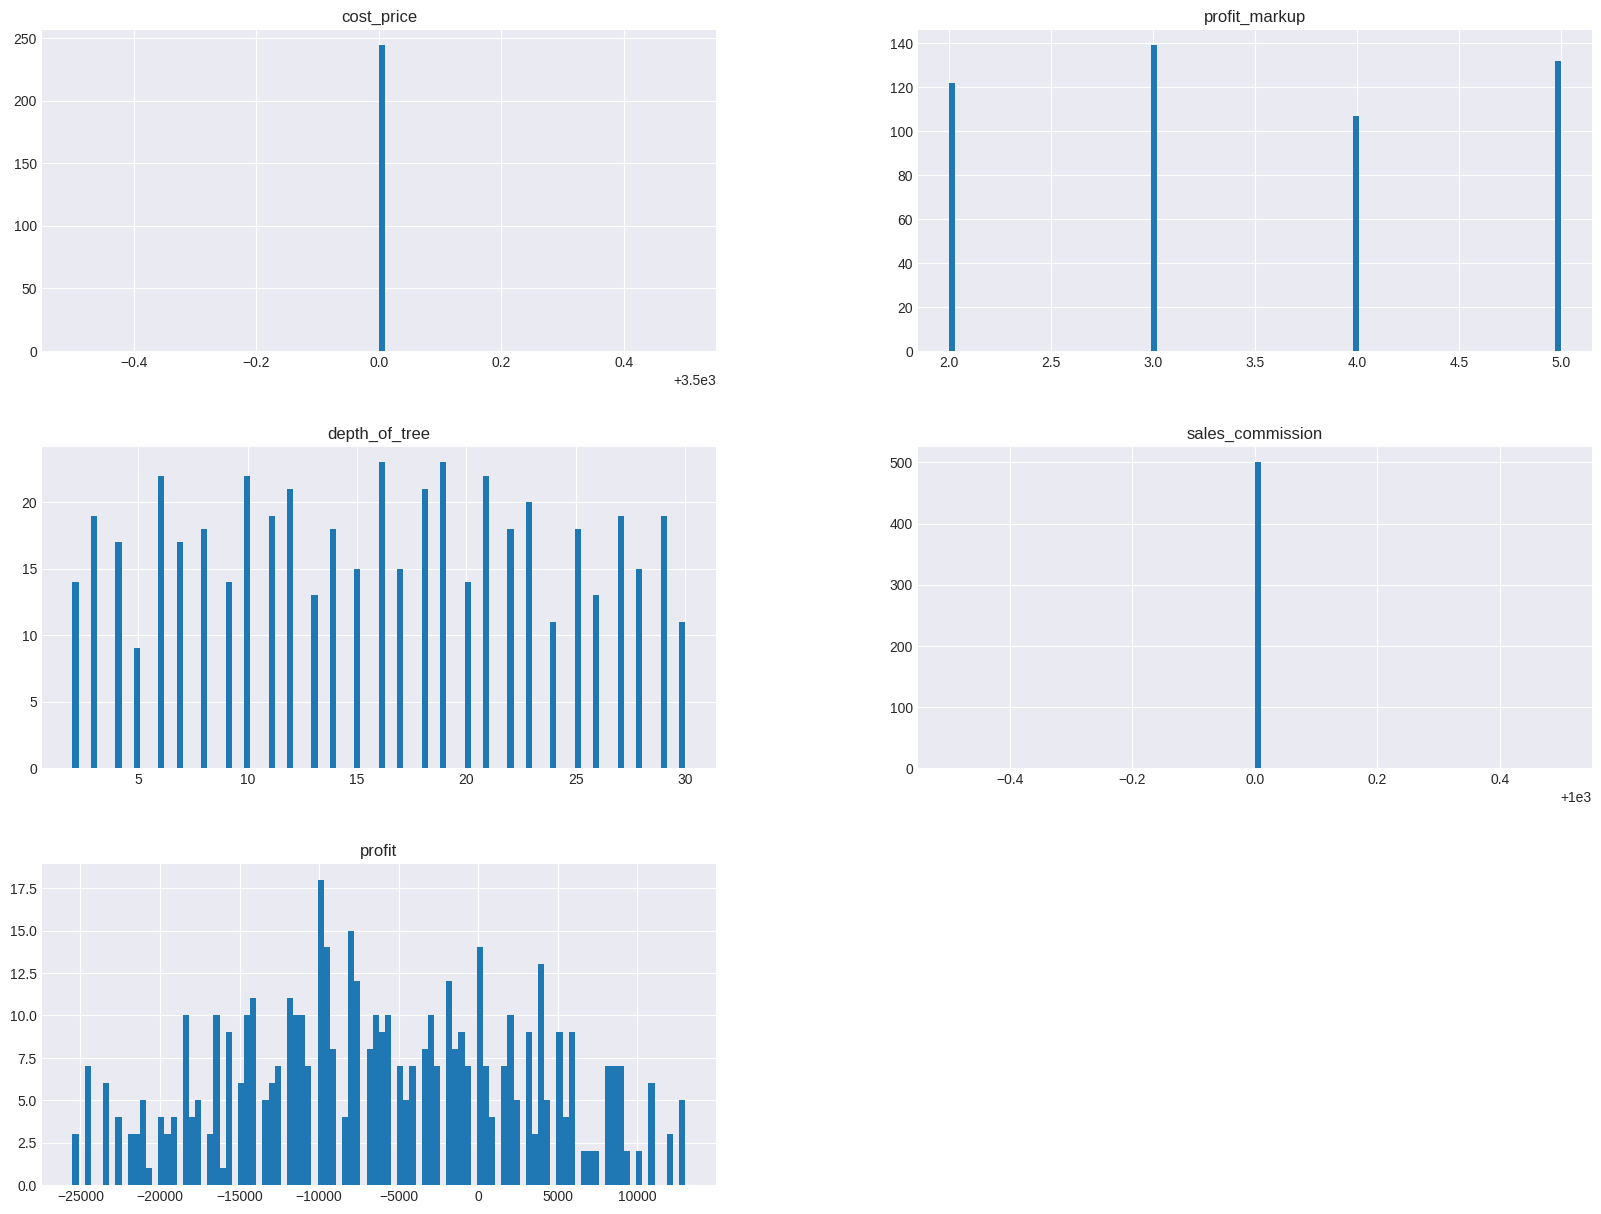


Матрица диаграмм рассеяния:


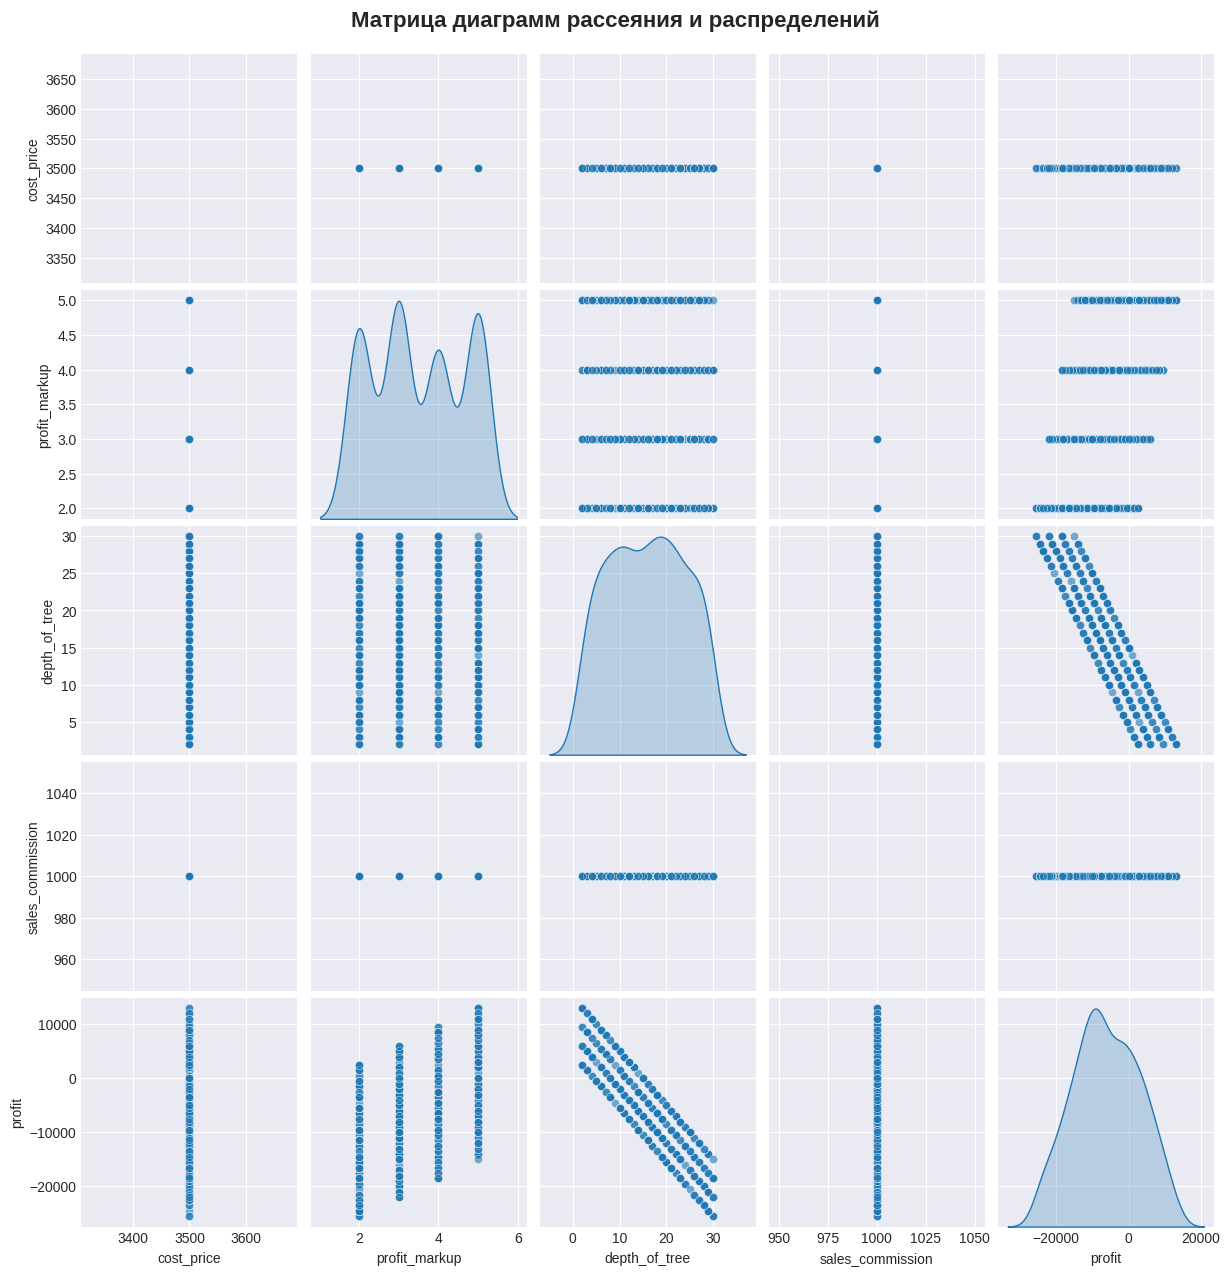

In [82]:
%matplotlib inline
df.hist(bins=100, figsize=(20,15))
plt.show()

# Матрица диаграмм рассеяния
print("\nМатрица диаграмм рассеяния:")
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Матрица диаграмм рассеяния и распределений', y=1.02, fontsize=16, fontweight='bold')
plt.show()

In [83]:
print(f"Количество строк до очистки: {len(df)}")

# Заполнение пропущенных значений в cost_price медианным значением
df['cost_price'] = df['cost_price'].fillna(df['cost_price'].median())
print("Пропущенные значения после обработки:")
print(df.isnull().sum())
df


3.c. Очистка данных
Количество строк до очистки: 500
Пропущенные значения после обработки:
cost_price          0
profit_markup       0
depth_of_tree       0
sales_commission    0
profit              0
dtype: int64


,cost_price,profit_markup,depth_of_tree,sales_commission,profit
0,3500.0,2,21,1000,-16500
1,3500.0,2,26,1000,-21500
2,3500.0,2,23,1000,-18500
3,3500.0,3,12,1000,-4000
4,3500.0,2,12,1000,-7500
...,...,...,...,...,...
495,3500.0,5,12,1000,3000
496,3500.0,3,8,1000,0
497,3500.0,2,10,1000,-5500
498,3500.0,4,21,1000,-9500


Корреляционная матрица:
                  cost_price  profit_markup  depth_of_tree  sales_commission  \
cost_price               NaN            NaN            NaN               NaN   
profit_markup            NaN       1.000000      -0.021562               NaN   
depth_of_tree            NaN      -0.021562       1.000000               NaN   
sales_commission         NaN            NaN            NaN               NaN   
profit                   NaN       0.453341      -0.900905               NaN   

                    profit  
cost_price             NaN  
profit_markup     0.453341  
depth_of_tree    -0.900905  
sales_commission       NaN  
profit            1.000000  


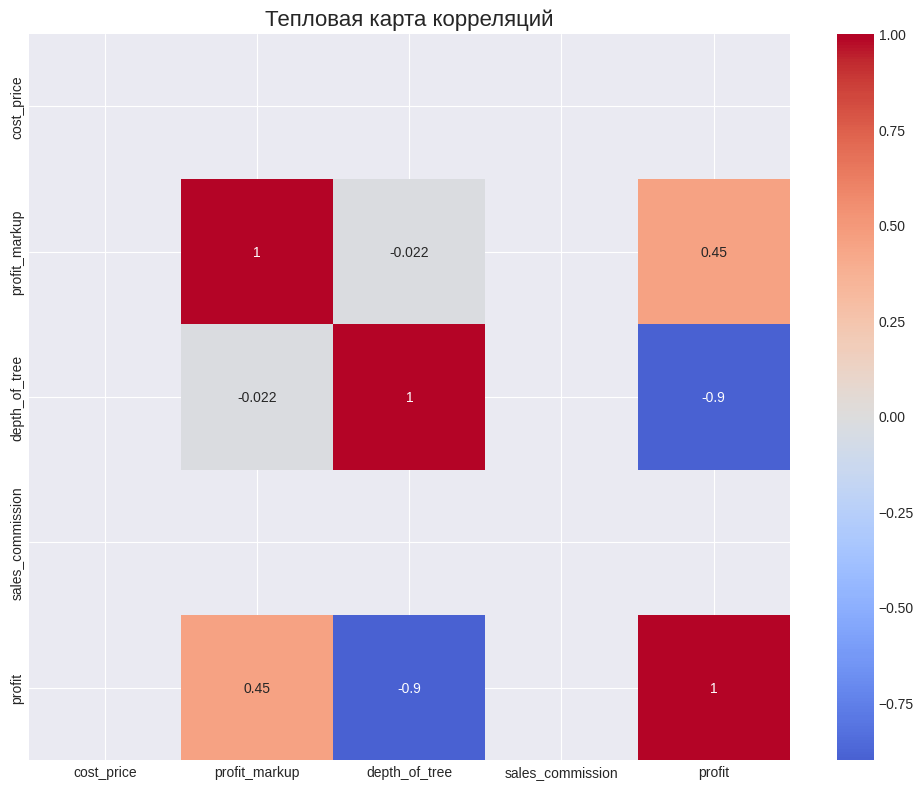

In [85]:
corr_matrix = df.corr()
print("Корреляционная матрица:")
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Тепловая карта корреляций', fontsize=16)
plt.tight_layout()
plt.show()

In [86]:
# Создание новых признаков
df['total_cost'] = df['cost_price'] + df['sales_commission']
df['profit_per_depth'] = df['profit'] / (df['depth_of_tree'] + 1)
df['markup_depth_interaction'] = df['profit_markup'] * df['depth_of_tree']
df['cost_markup_ratio'] = df['cost_price'] / (df['profit_markup'] + 1)

print("Добавлены новые признаки: total_cost, profit_per_depth, markup_depth_interaction, cost_markup_ratio")
print(df[['total_cost', 'profit_per_depth', 'markup_depth_interaction', 'cost_markup_ratio']].head())

Добавлены новые признаки: total_cost, profit_per_depth, markup_depth_interaction, cost_markup_ratio
   total_cost  profit_per_depth  markup_depth_interaction  cost_markup_ratio
0      4500.0       -750.000000                        42        1166.666667
1      4500.0       -796.296296                        52        1166.666667
2      4500.0       -770.833333                        46        1166.666667
3      4500.0       -307.692308                        36         875.000000
4      4500.0       -576.923077                        24        1166.666667


In [87]:
# Выбираем признаки с высокой корреляцией с целевой переменной
target_corr = corr_matrix['profit'].abs().sort_values(ascending=False)
print("Корреляция признаков с целевой переменной profit:")
print(target_corr)

Корреляция признаков с целевой переменной profit:
profit              1.000000
depth_of_tree       0.900905
profit_markup       0.453341
cost_price               NaN
sales_commission         NaN
Name: profit, dtype: float64


In [89]:
# Выбираем признаки с корреляцией > 0.1
significant_features = target_corr[target_corr > 0.1].index.tolist()
significant_features.remove('profit')
print(f"\nСущественные признаки: {significant_features}")


Существенные признаки: ['depth_of_tree', 'profit_markup']


In [90]:
# Создаем набор данных из существенных признаков
df_significant = df[significant_features + ['profit']].copy()
print(f"\nРазмерность набора с существенными признаками: {df_significant.shape}")


Размерность набора с существенными признаками: (500, 3)


In [101]:
# Функция для нормализации данных


def normalize_data(df_to_normalize, target_col='profit'):

    df_copy = df_to_normalize.copy()

    # Отделяем целевую переменную
    if target_col in df_copy.columns:
        y = df_copy[target_col]
        X = df_copy.drop(columns=[target_col])
    else:
        X = df_copy
        y = None

    # Нормализуем признаки
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

    # Восстанавливаем целевую переменную
    if y is not None:
        X_normalized_df[target_col] = y.values

    return X_normalized_df, scaler

# Нормализация исходного набора
df_original_normalized, scaler_original = normalize_data(df)

# Нормализация набора с существенными признаками
df_significant_normalized, scaler_significant = normalize_data(df_significant)

print("Исходный набор после нормализации:")
print(df_original_normalized.head())

print("\nНабор с существенными признаками после нормализации:")
print(df_significant_normalized.head())

Исходный набор после нормализации:
   cost_price  profit_markup  depth_of_tree  sales_commission  total_cost  \
0         0.0       0.000000       0.678571               0.0         0.0   
1         0.0       0.000000       0.857143               0.0         0.0   
2         0.0       0.000000       0.750000               0.0         0.0   
3         0.0       0.333333       0.357143               0.0         0.0   
4         0.0       0.000000       0.357143               0.0         0.0   

   profit_per_depth  markup_depth_interaction  cost_markup_ratio  profit  
0          0.014077                  0.260274                1.0  -16500  
1          0.005098                  0.328767                1.0  -21500  
2          0.010036                  0.287671                1.0  -18500  
3          0.099864                  0.219178                0.5   -4000  
4          0.047646                  0.136986                1.0   -7500  

Набор с существенными признаками после нормализации

In [147]:
datasets = {
    'original': df,  # Используем очищенный набор без столбца 'Unnamed: 0'
    'original_normalized': df_original_normalized,
    'significant': df_significant,
    'significant_normalized': df_significant_normalized
}

# Функция для разделения данных
def prepare_datasets(datasets_dict, test_size=0.2, val_size=0.2, random_state=42):
    prepared_data = {}

    for name, dataset in datasets_dict.items():
        # Определяем признаки и целевую переменную
        X = dataset.drop(columns=['profit'])
        y = dataset['profit']

        # Разделяем на обучающую+валидационную и тестовую
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Разделяем обучающую+валидационную на обучающую и валидационную
        val_size_adj = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size_adj, random_state=random_state
        )

        prepared_data[name] = {
            'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test
        }

        print(f"\n{name}:")
        print(f"  Обучающая выборка: {X_train.shape[0]} ")
        print(f"  Валидационная выборка: {X_val.shape[0]} ")
        print(f"  Тестовая выборка: {X_test.shape[0]} ")

    return prepared_data

# Подготавливаем все наборы данных
prepared_data = prepare_datasets(datasets)


original:
  Обучающая выборка: 300 
  Валидационная выборка: 100 
  Тестовая выборка: 100 

original_normalized:
  Обучающая выборка: 300 
  Валидационная выборка: 100 
  Тестовая выборка: 100 

significant:
  Обучающая выборка: 300 
  Валидационная выборка: 100 
  Тестовая выборка: 100 

significant_normalized:
  Обучающая выборка: 300 
  Валидационная выборка: 100 
  Тестовая выборка: 100 


In [111]:
# Функции для создания моделей
#Создание полносвязной нейронной сети
def create_fully_connected_model(input_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model

In [112]:
 #Создание простой рекуррентной сети (RNN) для регрессии
def create_rnn_model(input_dim, timesteps=1):
    model = models.Sequential([
        layers.Input(shape=(timesteps, input_dim)),  # Явное указание входного слоя
        layers.SimpleRNN(50, activation='relu', return_sequences=True),
        layers.SimpleRNN(30, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model

In [149]:
# Функции для оценки моделей
def evaluate_model(model, X_train, y_train, X_val, y_val, model_type='FC', epochs=50):
    """Обучение и оценка модели"""

    if model_type == 'RNN':
        # Для RNN преобразуем данные в 3D формат
        X_train_rnn = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_val_rnn = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

        history = model.fit(
            X_train_rnn, y_train,
            validation_data=(X_val_rnn, y_val),
            epochs=epochs,
            batch_size=16,
            verbose=0
        )

        # Прогнозы
        y_train_pred = model.predict(X_train_rnn, verbose=0).flatten()
        y_val_pred = model.predict(X_val_rnn, verbose=0).flatten()
    else:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=16,
            verbose=0
        )

        # Прогнозы
        y_train_pred = model.predict(X_train, verbose=0).flatten()
        y_val_pred = model.predict(X_val, verbose=0).flatten()

    # Метрики для обучающей выборки
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    # Метрики для валидационной выборки
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    return {
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'val_rmse': val_rmse,
        'val_r2': val_r2,
        'history': history,
        'model': model
    }

    # Сравнение моделей на всех наборах данных
results = {}
best_model_info = {'score': float('inf'), 'model_type': '', 'dataset': '', 'model': None, 'data': None}

for dataset_name, data_dict in prepared_data.items():
    print(f"Набор данных: {dataset_name}")

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']

input_dim = X_train.shape[1]

Набор данных: original
Набор данных: original_normalized
Набор данных: significant
Набор данных: significant_normalized


In [150]:
    # Полносвязная сеть
    print("\nПолносвязная нейронная сеть:")
    fc_model = create_fully_connected_model(input_dim)
    fc_results = evaluate_model(fc_model, X_train, y_train, X_val, y_val, 'FC', epochs=50)

    print(f"  RMSE (train): {fc_results['train_rmse']:.2f}")
    print(f"  R² (train): {fc_results['train_r2']:.4f}")
    print(f"  RMSE (val): {fc_results['val_rmse']:.2f}")
    print(f"  R² (val): {fc_results['val_r2']:.4f}")

    # Простая рекуррентная сеть (RNN)
    print("\nПростая рекуррентная сеть (RNN):")
    rnn_model = create_rnn_model(input_dim)
    rnn_results = evaluate_model(rnn_model, X_train, y_train, X_val, y_val, 'RNN', epochs=50)

    print(f"  RMSE (train): {rnn_results['train_rmse']:.2f}")
    print(f"  R² (train): {rnn_results['train_r2']:.4f}")
    print(f"  RMSE (val): {rnn_results['val_rmse']:.2f}")
    print(f"  R² (val): {rnn_results['val_r2']:.4f}")

    # Сохраняем результаты
    results[dataset_name] = {
        'FC': fc_results,
        'RNN': rnn_results
    }

    # Определяем лучшую модель по валидационному RMSE
    for model_type, model_results in [('FC', fc_results), ('RNN', rnn_results)]:
        if model_results['val_rmse'] < best_model_info['score']:
            best_model_info['score'] = model_results['val_rmse']
            best_model_info['model_type'] = model_type
            best_model_info['dataset'] = dataset_name
            best_model_info['model'] = model_results['model']
            best_model_info['data'] = data_dict

    print(f"\nЛучшая модель: {best_model_info['model_type']} на наборе {best_model_info['dataset']}")
    print(f"Лучший валидационный RMSE: {best_model_info['score']:.2f}")


Полносвязная нейронная сеть:
  RMSE (train): 4711.88
  R² (train): 0.7472
  RMSE (val): 4708.80
  R² (val): 0.7460

Простая рекуррентная сеть (RNN):
  RMSE (train): 4292.01
  R² (train): 0.7903
  RMSE (val): 4290.99
  R² (val): 0.7891

Лучшая модель: RNN на наборе significant_normalized
Лучший валидационный RMSE: 4290.99



Тестовый набор:
  RMSE: 3498.66
  R²: 0.7971


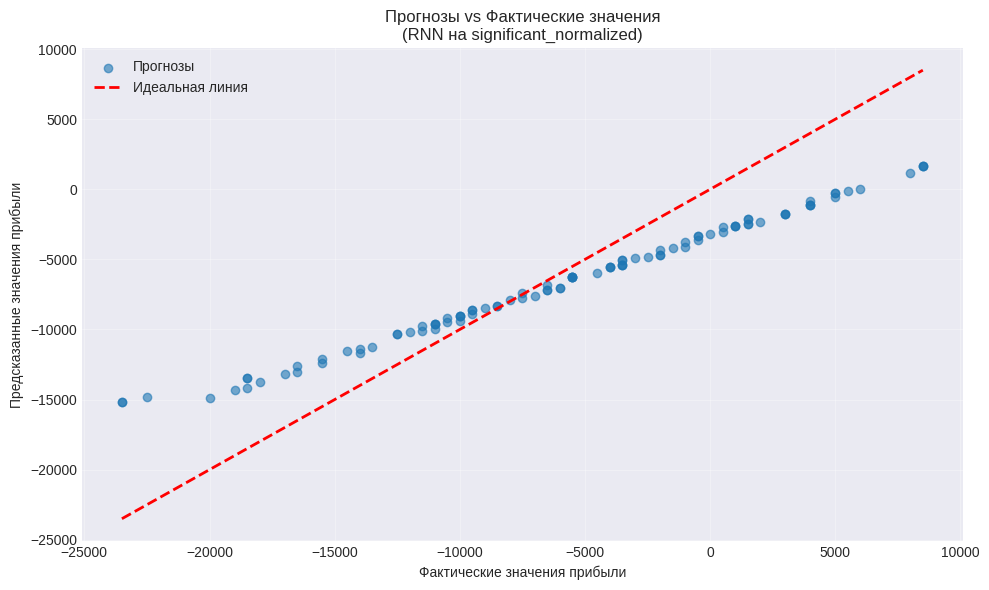

In [151]:
# 6. Оценка лучшей модели на тестовом наборе
# Получаем тестовые данные
X_test = best_model_info['data']['X_test']
y_test = best_model_info['data']['y_test']

# Прогноз на тестовом наборе
if best_model_info['model_type'] == 'RNN':
    X_test_rnn = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
    y_test_pred = best_model_info['model'].predict(X_test_rnn, verbose=0).flatten()
else:
    y_test_pred = best_model_info['model'].predict(X_test, verbose=0).flatten()

# Метрики на тестовом наборе
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nТестовый набор:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R²: {test_r2:.4f}")

# Визуализация прогнозов
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, label='Прогнозы')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Идеальная линия')
plt.xlabel('Фактические значения прибыли')
plt.ylabel('Предсказанные значения прибыли')
plt.title(f'Прогнозы vs Фактические значения\n({best_model_info["model_type"]} на {best_model_info["dataset"]})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [152]:
# 7. Grid поиск лучших гиперпараметров (упрощенный вариант)
print("\n" + "="*80)
print("7. GRID ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ")
print("="*80)

# Используем лучший набор данных
best_dataset_name = best_model_info['dataset']
best_data = prepared_data[best_dataset_name]
X_train = best_data['X_train']
y_train = best_data['y_train']
X_val = best_data['X_val']
y_val = best_data['y_val']

input_dim = X_train.shape[1]

# Определяем параметры для GridSearch
param_grid = {
    'units': [32, 64, 128],
    'dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [30, 50]
}

# Создаем упрощенную сетку для демонстрации
simple_param_grid = [
    {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 30},
    {'units': 128, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 30},
    {'units': 64, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 30},
    {'units': 64, 'dropout': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 30},
    {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30},
    {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 50},
]

# Функция для создания и обучения модели с заданными параметрами
def train_model_with_params(params, input_dim, X_train, y_train, X_val, y_val):
    model = models.Sequential([
        layers.Dense(params['units'], activation='relu', input_dim=input_dim),
        layers.Dropout(params['dropout']),
        layers.Dense(params['units']//2, activation='relu'),
        layers.Dropout(params['dropout']),
        layers.Dense(params['units']//4, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    # Прогноз на валидационной выборке
    y_val_pred = model.predict(X_val, verbose=0).flatten()
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    return model, history, val_rmse

print("Выполняется GridSearch по 6 комбинациям параметров...")

# Запускаем GridSearch
best_grid_model = None
best_grid_params = None
best_grid_rmse = float('inf')
grid_results = []

for i, params in enumerate(simple_param_grid):
    print(f"\nКомбинация {i+1}/{len(simple_param_grid)}: {params}")

    # Обучаем модель
    model, history, val_rmse = train_model_with_params(params, input_dim, X_train, y_train, X_val, y_val)

    grid_results.append({
        'params': params,
        'model': model,
        'history': history,
        'val_rmse': val_rmse
    })

    print(f"  Val RMSE: {val_rmse:.2f}")

    # Сохраняем лучшую модель
    if val_rmse < best_grid_rmse:
        best_grid_rmse = val_rmse
        best_grid_model = model
        best_grid_params = params

# Выводим результаты GridSearch
print(f"\n{'='*60}")
print("РЕЗУЛЬТАТЫ GRID ПОИСКА")
print(f"{'='*60}")

# Сортируем результаты по RMSE
sorted_results = sorted(grid_results, key=lambda x: x['val_rmse'])

print("\nТоп-3 лучших комбинаций параметров:")
for i, result in enumerate(sorted_results[:3]):
    print(f"\n{i+1}. RMSE: {result['val_rmse']:.2f}")
    for key, value in result['params'].items():
        print(f"   {key}: {value}")

print(f"\nЛучшие параметры: {best_grid_params}")
print(f"Лучший RMSE после GridSearch: {best_grid_rmse:.2f}")


7. GRID ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ
Выполняется GridSearch по 6 комбинациям параметров...

Комбинация 1/6: {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 30}
  Val RMSE: 6617.90

Комбинация 2/6: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 30}


  Val RMSE: 3653.69

Комбинация 3/6: {'units': 64, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 30}


  Val RMSE: 6924.17

Комбинация 4/6: {'units': 64, 'dropout': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 30}
  Val RMSE: 1050.17

Комбинация 5/6: {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
  Val RMSE: 10507.53

Комбинация 6/6: {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 50}
  Val RMSE: 2444.84

РЕЗУЛЬТАТЫ GRID ПОИСКА

Топ-3 лучших комбинаций параметров:

1. RMSE: 1050.17
   units: 64
   dropout: 0.2
   learning_rate: 0.01
   batch_size: 16
   epochs: 30

2. RMSE: 2444.84
   units: 64
   dropout: 0.2
   learning_rate: 0.001
   batch_size: 16
   epochs: 50

3. RMSE: 3653.69
   units: 128
   dropout: 0.2
   learning_rate: 0.001
   batch_size: 16
   epochs: 30

Лучшие параметры: {'units': 64, 'dropout': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 30}
Лучший RMSE после GridSearch: 1050.17



8. ОЦЕНКА МОДЕЛИ ПОСЛЕ GRID ПОИСКА

Сравнение качества моделей на тестовом наборе:
Модель                         RMSE            R²             
------------------------------------------------------------
До GridSearch                  3498.66         0.7971         
После GridSearch               735.39          0.9910         
Улучшение                      2763.28         0.1939         
Процент улучшения RMSE: 79.0%


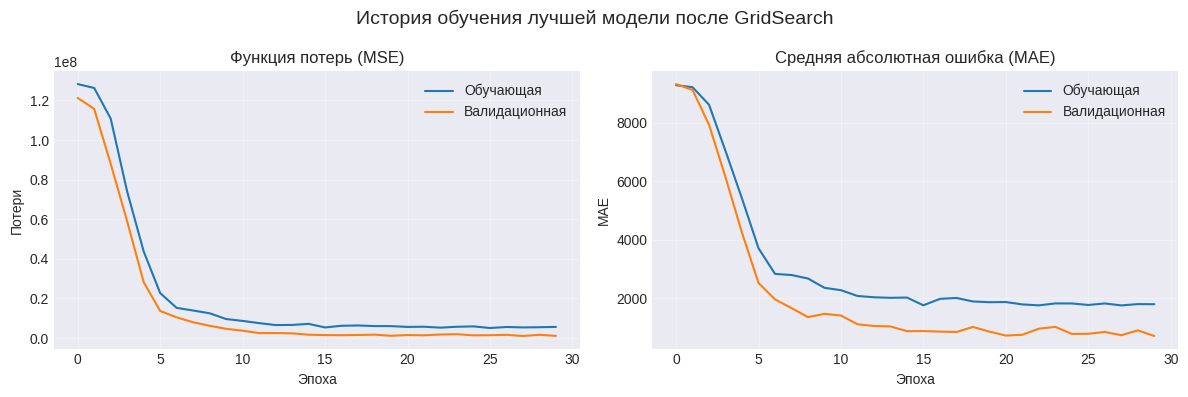

In [153]:
# 8. Оценка модели после Grid поиска
print("\n" + "="*80)
print("8. ОЦЕНКА МОДЕЛИ ПОСЛЕ GRID ПОИСКА")
print("="*80)

# Прогноз на тестовом наборе
y_test_pred_grid = best_grid_model.predict(X_test, verbose=0).flatten()

# Метрики на тестовом наборе
test_rmse_grid = np.sqrt(mean_squared_error(y_test, y_test_pred_grid))
test_r2_grid = r2_score(y_test, y_test_pred_grid)

print("\nСравнение качества моделей на тестовом наборе:")
print(f"{'Модель':<30} {'RMSE':<15} {'R²':<15}")
print(f"{'-'*60}")
print(f"{'До GridSearch':<30} {test_rmse:<15.2f} {test_r2:<15.4f}")
print(f"{'После GridSearch':<30} {test_rmse_grid:<15.2f} {test_r2_grid:<15.4f}")

if test_rmse_grid < test_rmse:
    improvement = test_rmse - test_rmse_grid
    r2_improvement = test_r2_grid - test_r2
    print(f"{'Улучшение':<30} {improvement:<15.2f} {r2_improvement:<15.4f}")
    improvement_percent = (improvement / test_rmse) * 100
    print(f"Процент улучшения RMSE: {improvement_percent:.1f}%")
else:
    print(f"{'Ухудшение':<30} {(test_rmse_grid - test_rmse):<15.2f} {(test_r2 - test_r2_grid):<15.4f}")

# Визуализация истории обучения лучшей модели после GridSearch
best_grid_result = sorted_results[0]
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_grid_result['history'].history['loss'], label='Обучающая')
plt.plot(best_grid_result['history'].history['val_loss'], label='Валидационная')
plt.title('Функция потерь (MSE)')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(best_grid_result['history'].history['mae'], label='Обучающая')
plt.plot(best_grid_result['history'].history['val_mae'], label='Валидационная')
plt.title('Средняя абсолютная ошибка (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle('История обучения лучшей модели после GridSearch', fontsize=14)
plt.tight_layout()
plt.show()